### Causal Networks Exploration
#### Author: Melissa Osquist
#### Date: November 28, 2021

In [1]:
import numpy as np
import random as py_random
import numpy.random as np_random
import time
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
import patsy
import sklearn.linear_model as linear
import dowhy
from dowhy import CausalModel
import pygraphviz
from IPython.display import Image, display

#### Load Sample Data for Causal Network 
The sample data contains eight binary variables. 
asia: if subject has a recent visit to asia.
tub: if subject has tuberculosis
smoke: if suject is a smoker
lung: if subject has lung cancer
bronc: if subject has bronchitis
either: if subject has tuberculosis or lung cancer
xray: if an xray shows signs of tuberculosis or lung cancer
dysp: if subject has dyspnoea (difficulty breathing)

In [2]:
df = pd.read_csv("ASIA10k.csv")

In [3]:
df["asia"] = df.asia.apply(lambda asia: True if asia == 'yes' else False)
df["tub"] = df.tub.apply(lambda tub: True if tub == 'yes' else False)
df["smoke"] = df.smoke.apply(lambda smoke: True if smoke == 'yes' else False)
df["lung"] = df.lung.apply(lambda lung: True if lung == 'yes' else False)
df["bronc"] = df.bronc.apply(lambda bronc: True if bronc == 'yes' else False)
df["either"] = df.either.apply(lambda either: True if either == 'yes' else False)
df["xray"] = df.xray.apply(lambda xray: True if xray == 'yes' else False)
df["dysp"] = df.dysp.apply(lambda dysp: True if dysp == 'yes' else False)

In [4]:
df.head()

,asia,tub,smoke,lung,bronc,either,xray,dysp
0,False,False,False,False,False,False,False,True
1,False,False,True,False,False,False,False,False
2,False,False,False,False,False,False,False,False
3,False,False,True,False,False,False,False,False
4,False,False,True,False,True,False,False,True


Below is the expected causal graph based on known causalities as follows. A trip to asia causes an increased risk of tuberculosis. Smoking causes lung cancer and bronchitis. Lung cancer and tuberculosis both cause a positive chest xray. Bronchitis or lung cancer or tuberculosis can cause dyspnoea. 

[bnlearn] >Import <asia>
[bnlearn] >Loading bif file </Users/mosquist/opt/anaconda3/lib/python3.8/site-packages/bnlearn/data/asia.bif>
[bnlearn]> Set node properties.
[bnlearn] >Plot based on BayesianModel


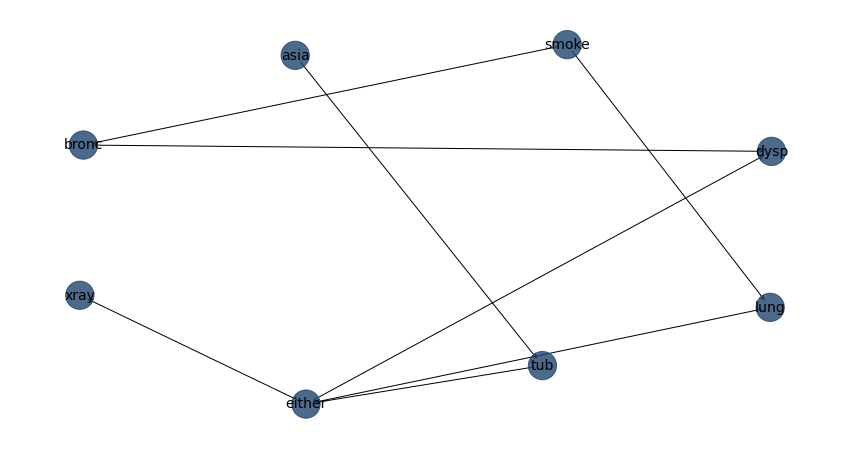

In [5]:
import bnlearn as bn
model = bn.import_DAG('asia', CPD=False)
G = bn.plot(model)

#### Learn Causal Graph

Attempt to learn the causal graph with the bnlearn library. 

[bnlearn] >Computing best DAG using [hc]
[bnlearn] >Set scoring type at [bic]
[bnlearn]> Set node properties.
[bnlearn] >Plot based on BayesianModel


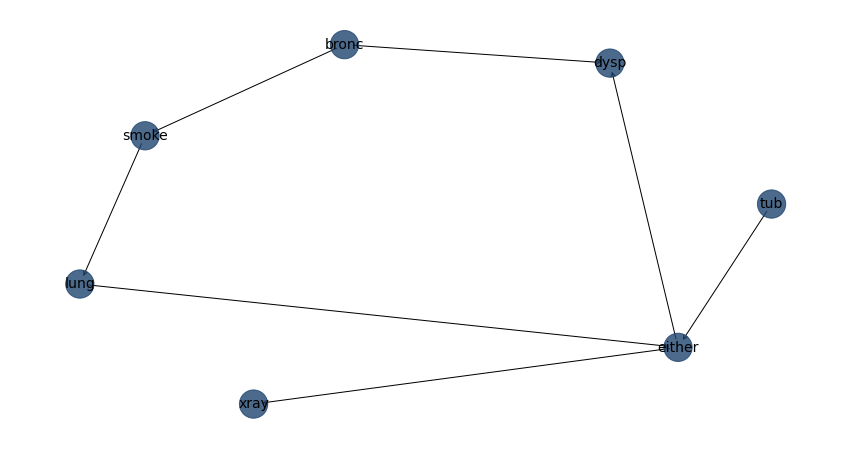

In [6]:
model = bn.structure_learning.fit(df)
G = bn.plot(model)

With default settings (hillClimbSearch algorithm), the resulting structure is missing 'asia' and included one incorrectly oriented edge from bronc to smoking (we know from domain knowledge that smoking is a cause of bronchitis not the other way around); however the structure is quite close to the "true" structure. 

[bnlearn] >Computing best DAG using [chow-liu]


Building tree:   0%|          | 0/28.0 [00:00<?, ?it/s]

[bnlearn]> Set node properties.
[bnlearn] >Plot based on BayesianModel


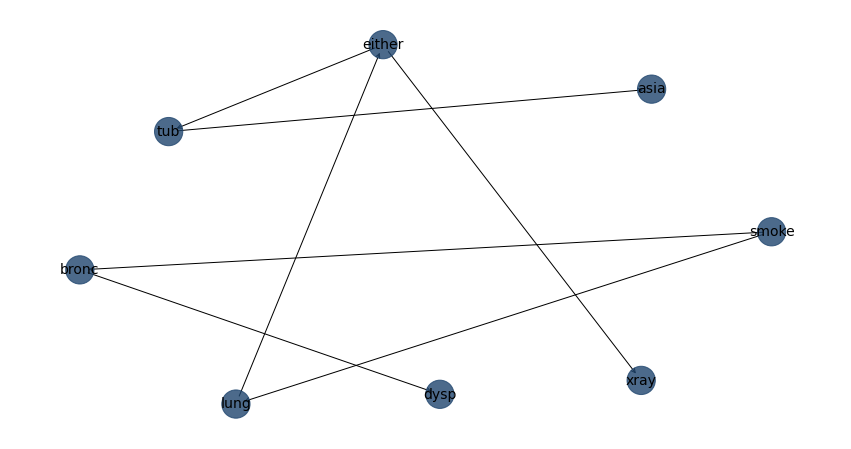

In [7]:
model = bn.structure_learning.fit(df, methodtype='cl', root_node='smoke')
G = bn.plot(model)

The Chow-Liu algorithm produces a graph that includes all nodes, but many edges are oriented in the wrong direction and there is a missing edge between either and dyspnoea.

[bnlearn] >Computing best DAG using [cs]


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[bnlearn]> Set node properties.
[bnlearn] >Plot based on BayesianModel


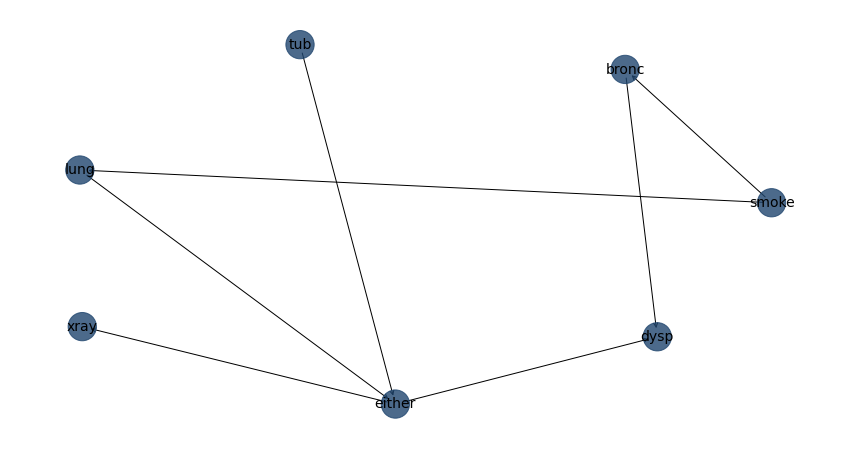

In [8]:
model = bn.structure_learning.fit(df, methodtype='cs', scoretype='k2')
G = bn.plot(model)

The constraint based scoring, produces the expected graph, except for the omission of asia and its causal relationship with tuberculosis. The arrows are all oriented in the correct direction to show the expected causality. 

A final option is an exhaustive search (code shown below). This was not run because it did not complete in a reasonable time. So while bnlearn does offer an exhaustive search it is not reasonable. 

model = bn.structure_learning.fit(df, methodtype='ex', scoretype='k2')

G = bn.plot(model)

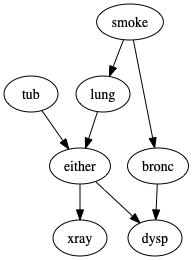

In [9]:
model=CausalModel(
        data = df,
        treatment='bronc',
        outcome='dysp',
        graph="""graph[directed 1 node[id "tub" label "tub"]
                    node[id "either" label "either"]
                    node[id "lung" label "lung"]
                    node[id "dysp" label "dysp"]
                    node[id "smoke" label "smoke"]
                    node[id "bronc" label "bronc"]
                    node[id "xray" label "xray"]
                    edge[source "either" target "xray"]
                    edge[source "smoke" target "lung"]
                    edge[source "lung" target "either"]
                    edge[source "smoke" target "bronc"]
                    edge[source "bronc" target "dysp"]
                    edge[source "tub" target "either"]
                    edge[source "either" target "dysp"]]"""

        )
model.view_model()
display(Image(filename="causal_model.png"))

A cleaner model of the graph generated by the bnlearn constraint based algorithm. 

Now we add in the asia node and edge to tub as well as some unobserved confounders and use the Microsoft DoWhy library to estimate the causal relationship between brochitis and dyspnoea. The DoWhy library will provide an estimate of the causal effect of a treatment variable on an outcome variable and consider if this effect could be explained by some unobserved confounding variable. Here, for example, there might be some latent variable that causes both bronchitis and dyspnoea. 

In [10]:
causal_graph = """digraph {
asia[label="asia"];
tub[label="tub"];
smoke[label="smoke"];
lung[label="lung"];
bronc[label="bronc"];
either[label="either"];
xray[label="xray"];
dysp[label="dysp"];
U[label = "Unobserved Confounders"]
asia->tub;
smoke->lung; smoke->bronc;
lung->either;
bronc->dysp;
tub->either;
either->dysp;
either->xray;
U->dysp; U->bronc; 
}"""

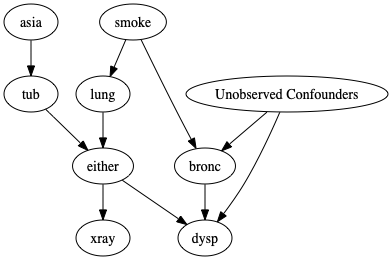

In [11]:
model= dowhy.CausalModel(
        data = df,
        graph=causal_graph.replace("\n", " "),
        treatment='bronc',
        outcome='dysp')
model.view_model()
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

In [12]:
#Identify the causal effect
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                                                       
────────(Expectation(dysp|xray,asia,tub,lung,smoke,either))
d[bronc]                                                   
Estimand assumption 1, Unconfoundedness: If U→{bronc} and U→dysp then P(dysp|bronc,xray,asia,tub,lung,smoke,either,U) = P(dysp|bronc,xray,asia,tub,lung,smoke,either)

### Estimand : 2
Estimand name: iv
No such variable found!

### Estimand : 3
Estimand name: frontdoor
No such variable found!



In [13]:
estimate = model.estimate_effect(identified_estimand,
                                 method_name="backdoor1.propensity_score_matching",
                                target_units="att")
print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

## Realized estimand
b: dysp~bronc+xray+asia+tub+lung+smoke+either
Target units: att

## Estimate
Mean value: 0.7343189964157706



In [14]:
estimate2 = model.estimate_effect(identified_estimand,
                                 method_name="backdoor.propensity_score_stratification",target_units="ate")
# ATE = Average Treatment Effect
# ATT = Average Treatment Effect on Treated
# ATC = Average Treatment Effect on Control 
print(estimate2)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                                                       
────────(Expectation(dysp|xray,asia,tub,lung,smoke,either))
d[bronc]                                                   
Estimand assumption 1, Unconfoundedness: If U→{bronc} and U→dysp then P(dysp|bronc,xray,asia,tub,lung,smoke,either,U) = P(dysp|bronc,xray,asia,tub,lung,smoke,either)

## Realized estimand
b: dysp~bronc+xray+asia+tub+lung+smoke+either
Target units: ate

## Estimate
Mean value: 0.6845210897454275



In [15]:
causal_estimate_ipw = model.estimate_effect(identified_estimand,
                                            method_name="backdoor.propensity_score_weighting",
                                            target_units = "ate",
                                            method_params={"weighting_scheme":"ips_weight"})
print(causal_estimate_ipw)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                                                       
────────(Expectation(dysp|xray,asia,tub,lung,smoke,either))
d[bronc]                                                   
Estimand assumption 1, Unconfoundedness: If U→{bronc} and U→dysp then P(dysp|bronc,xray,asia,tub,lung,smoke,either,U) = P(dysp|bronc,xray,asia,tub,lung,smoke,either)

## Realized estimand
b: dysp~bronc+xray+asia+tub+lung+smoke+either
Target units: ate

## Estimate
Mean value: 0.6838985405153926



Three different algorithms for estimating the causal effect of bronchitis on dyspnoea were tested. The doWhy librabry offers other algorithms that would be applicable to continuous data. Given that we are working with categorical data, these three algorithms were selected for their applicability to this problem. The three methods used are "backdoor propensity score matching", "backdoor propensity score stratification", and "backdoor propensity score weighting". All three algorithms or variations produce similar estimates for the causal effect ranging from 0.684 to 0.734. The next step is to see if we can refute these estimates. Again, doWhy offers a variety of estimates to make refutals. We will try adding a random common cause, if the causal relationship between bronchitis and dyspnoea is valid, this should not change the causal estimate. We can try adding a placebo treatement, which should give a causal estimate of zero since the placebo should not alter the outcome. And finally we will try a data subset refuter which breaks the data into subsets and measures the causal effect across subsets (it should be consistent). 

In [16]:
refute1_results=model.refute_estimate(identified_estimand, estimate2,
        method_name="random_common_cause")
print(refute1_results)

Refute: Add a Random Common Cause
Estimated effect:0.6845210897454275
New effect:0.6845262999802841



In [17]:
refute2_results=model.refute_estimate(identified_estimand, estimate2,
        method_name="placebo_treatment_refuter")
print(refute2_results)

Refute: Use a Placebo Treatment
Estimated effect:0.6845210897454275
New effect:-0.0016955753471796003
p value:0.47



In [18]:
refute3_results=model.refute_estimate(identified_estimand, estimate2,
        method_name="data_subset_refuter")
print(refute3_results)

Refute: Use a subset of data
Estimated effect:0.6845210897454275
New effect:0.6843785159881307
p value:0.49



All three attempts to refute the causal relationship failed (did not refute the relationship) so we have some evidence that there is a strong causal relationship between bronchitis and dyspnoea based on the data and model we have provided. 

For comparison, let's explore a model with an incorrectly oriented edge from dyspnoea to bronchitis indicating falsely that dyspnoea causes bronchitis. While we know this to be false, if we were tackling a problem with an incomplete model and relying on learning the bayesian network it is possible that we would have an incorrectly oriented edge. 

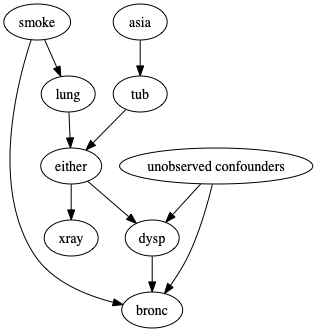

In [19]:
bad_model=CausalModel(
        data = df,
        treatment='dysp',
        outcome='bronc',
        graph="""graph[directed 1 node[id "tub" label "tub"]
                    node[id "either" label "either"]
                    node[id "lung" label "lung"]
                    node[id "dysp" label "dysp"]
                    node[id "smoke" label "smoke"]
                    node[id "bronc" label "bronc"]
                    node[id "xray" label "xray"]
                    node[id "asia" label "asia"]
                    node[id "U" label "unobserved confounders"]
                    edge[source "asia" target "tub"]
                    edge[source "tub" target "either"]
                    edge[source "either" target "xray"]
                    edge[source "dysp" target "bronc"]
                    edge[source "smoke" target "lung"]
                    edge[source "lung" target "either"]
                    edge[source "either" target "dysp"]
                    edge[source "U" target "dysp"]
                    edge[source "U" target "bronc"]
                    edge[source "smoke" target "bronc"]
                    ]"""

        )
bad_model.view_model()
display(Image(filename="causal_model.png"))

In [20]:
bad_estimand = bad_model.identify_effect(proceed_when_unidentifiable=True)
print(bad_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                                                       
───────(Expectation(bronc|xray,asia,tub,lung,smoke,either))
d[dysp]                                                    
Estimand assumption 1, Unconfoundedness: If U→{dysp} and U→bronc then P(bronc|dysp,xray,asia,tub,lung,smoke,either,U) = P(bronc|dysp,xray,asia,tub,lung,smoke,either)

### Estimand : 2
Estimand name: iv
No such variable found!

### Estimand : 3
Estimand name: frontdoor
No such variable found!



In [21]:
bad_estimate = bad_model.estimate_effect(bad_estimand,
                                 method_name="backdoor.propensity_score_stratification",target_units="ate")
print(bad_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                                                       
───────(Expectation(bronc|xray,asia,tub,lung,smoke,either))
d[dysp]                                                    
Estimand assumption 1, Unconfoundedness: If U→{dysp} and U→bronc then P(bronc|dysp,xray,asia,tub,lung,smoke,either,U) = P(bronc|dysp,xray,asia,tub,lung,smoke,either)

## Realized estimand
b: bronc~dysp+xray+asia+tub+lung+smoke+either
Target units: ate

## Estimate
Mean value: 0.6717026082545592



In [22]:
bad_estimate2 = bad_model.estimate_effect(bad_estimand,
                                 method_name="backdoor.propensity_score_stratification",target_units="ate")
print(bad_estimate2)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                                                       
───────(Expectation(bronc|xray,asia,tub,lung,smoke,either))
d[dysp]                                                    
Estimand assumption 1, Unconfoundedness: If U→{dysp} and U→bronc then P(bronc|dysp,xray,asia,tub,lung,smoke,either,U) = P(bronc|dysp,xray,asia,tub,lung,smoke,either)

## Realized estimand
b: bronc~dysp+xray+asia+tub+lung+smoke+either
Target units: ate

## Estimate
Mean value: 0.6717026082545592



In [23]:
bad_estimate3 = bad_model.estimate_effect(bad_estimand,
                                            method_name="backdoor.propensity_score_weighting",
                                            target_units = "ate",
                                            method_params={"weighting_scheme":"ips_weight"})
print(bad_estimate3 )

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                                                       
───────(Expectation(bronc|xray,asia,tub,lung,smoke,either))
d[dysp]                                                    
Estimand assumption 1, Unconfoundedness: If U→{dysp} and U→bronc then P(bronc|dysp,xray,asia,tub,lung,smoke,either,U) = P(bronc|dysp,xray,asia,tub,lung,smoke,either)

## Realized estimand
b: bronc~dysp+xray+asia+tub+lung+smoke+either
Target units: ate

## Estimate
Mean value: 0.6701508239130379



With the incorrectly oriented edge from dyspnoea to bronchitis, we see that there is a similar causal estimate to what we saw with the correclty oriented edge. Now let's see if any of the refuters will refute the model. 

In [24]:
brefute1_results=bad_model.refute_estimate(bad_estimand, bad_estimate2,
        method_name="random_common_cause")
print(brefute1_results)

Refute: Add a Random Common Cause
Estimated effect:0.6717026082545592
New effect:0.6712866361125923



In [25]:
brefute2_results=bad_model.refute_estimate(bad_estimand, bad_estimate2,
        method_name="placebo_treatment_refuter")
print(brefute2_results)

Refute: Use a Placebo Treatment
Estimated effect:0.6717026082545592
New effect:-0.00012121440138544918
p value:0.49



In [26]:
brefute3_results=bad_model.refute_estimate(bad_estimand, bad_estimate2,
        method_name="data_subset_refuter")
print(brefute3_results)

Refute: Use a subset of data
Estimated effect:0.6717026082545592
New effect:0.6739930390245541
p value:0.32



#### Comparison to Probablistic Models
For comparison, let's look at some probability models. First, we can look at the joint probability of bronchitis and dyspnoea, $P(bronc, dysp)$

In [27]:
df["dysp"].describe()

count     10000
unique        2
top       False
freq       5636
Name: dysp, dtype: object

In [28]:
pd.crosstab(df["bronc"], df["dysp"], normalize="index")

dysp,False,True
bronc,,
False,0.873013,0.126987
True,0.179884,0.820116


The joint probability indicates that there is a 82% chance of having bronchitis and having dyspnoea. Now we will look at how a Naive Bayes Classifer would make predictions about this dataset. First we will encode the Naive Bayes classifier from the sklearn library using the categories that could cause Dyspnoea (smoking, lung cancer, tuberculosis, and bronchitis)

In [29]:
from sklearn.naive_bayes import CategoricalNB
from sklearn.preprocessing import OrdinalEncoder

encoder = OrdinalEncoder()
encoder.fit(df[["smoke","lung","tub","bronc"]])
encoder.categories_

[array([False,  True]),
 array([False,  True]),
 array([False,  True]),
 array([False,  True])]

In [30]:
clf = CategoricalNB()
clf.fit(encoder.transform(df[["smoke","lung","tub","bronc"]]), df["dysp"]);

In [31]:
def display_prediction(probs):
    print(f"P(~dysp|*): {probs[0][0]}")
    print(f"P(dysp|*): {probs[0][1]}")

We can ask the naive bayes classifier to predict if an individual will have dyspnoea. Our first individual is a nonsmoker without lung cancer or tuberculosis, but does have bronchitis. What is $P(dysp | \lnot smoke,  \lnot lung,  \lnot tub, bronc)$?

In [32]:
prediction_1 = clf.predict_proba(encoder.transform([(False, False, False, True)]))
display_prediction(prediction_1)

P(~dysp|*): 0.287980280042042
P(dysp|*): 0.7120197199579579


So using the naive Bayes classifier, someone who is not a smoker, does not have lung cancer or tuberculosis, but does have bronchitis has a 71% chance of having dyspnoea. This is less than the joint probability in the original dataset, but that could be the difference of being a smoker with bronchitis (or having lung cancer or tuberculosis as well). Knowing smoking is a cause of bronchitis, let's also look at an inidividual who is a smoker and has bronchitis. 

In [33]:
prediction_2 = clf.predict_proba(encoder.transform([(True, False, False, True)]))
display_prediction(prediction_2)

P(~dysp|*): 0.13054905704068961
P(dysp|*): 0.8694509429593102


The naive bayes predicts that a smoker with bronchitis has an 87% chance of having dyspnoea. 

The naive bayes is drawing its conclusions from probabilistic reasoning based on the data we have. The questions we are answering with this model are those like, "given that we have observed that someone has bronchitis, is a nonsmoker, does not have lung cancer or tuberculosis, what are the chances that they have dyspnoea?". The assumption is that we have the data on the attributes of this individual. We have observed these specific values for each variable. With causal networks we want to be able to ask questions like, "if we force an individual to have bronchitis, what is the chance they will have dyspnoea?" which is not intuitive so perhaps a better example, is "if we force someone to smoke, what is the chance they will develop bronchitis?". The difference is with probability we observe that an individual is a smoker and based on what we know about other smokers, we can give some likelihood that they will have dyspnoea. 

#### Using causalnex to Perform Interventions
Now we will look at the causalnex library first to seee if it can predict our model then to perform interventions and make queries about the effect of interventions. 

In [34]:
import warnings
from causalnex.structure import StructureModel

warnings.filterwarnings("ignore")  # silence warnings

We need to reformat our data to use causalnex

In [35]:
df["asia"] = df.asia.apply(lambda asia: 1 if asia == True else 0)
df["tub"] = df.tub.apply(lambda tub: 1 if tub == True else 0)
df["smoke"] = df.smoke.apply(lambda smoke: 1 if smoke == True else 0)
df["lung"] = df.lung.apply(lambda lung: 1 if lung == True else 0)
df["bronc"] = df.bronc.apply(lambda bronc: 1 if bronc == True else 0)
df["either"] = df.either.apply(lambda either: 1 if either == True else 0)
df["xray"] = df.xray.apply(lambda xray: 1 if xray == True else 0)
df["dysp"] = df.dysp.apply(lambda dysp: 1 if dysp == True else 0)

In [36]:
df = df[['asia','tub','smoke','lung','bronc','either','xray','dysp']].copy()

In [37]:
df.head()

,asia,tub,smoke,lung,bronc,either,xray,dysp
0,0,0,0,0,0,0,0,1
1,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0
4,0,0,1,0,1,0,0,1


In [38]:
from causalnex.structure.notears import from_pandas
sm = from_pandas(df)

Here we can use the algorithms for learning the causal network from the causalnex library. 

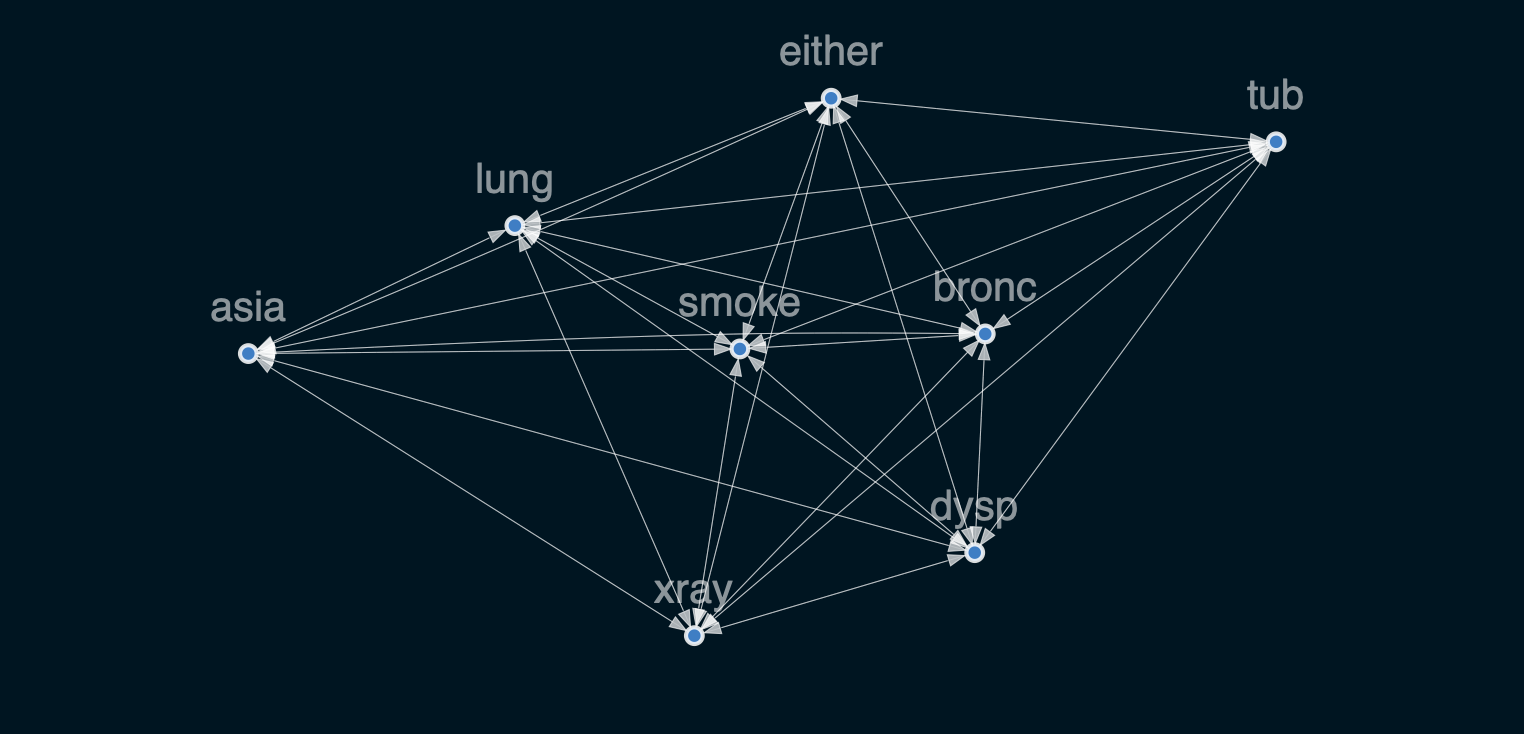

In [39]:
from IPython.display import Image
from causalnex.plots import plot_structure, NODE_STYLE, EDGE_STYLE
viz = plot_structure(
    sm,
    graph_attributes={"scale": "0.5"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK,
    prog='fdp',
)
Image(viz.draw(format='png'))

This graph has too many edges, so we can adjust the threshold and drop those that are weaker. 

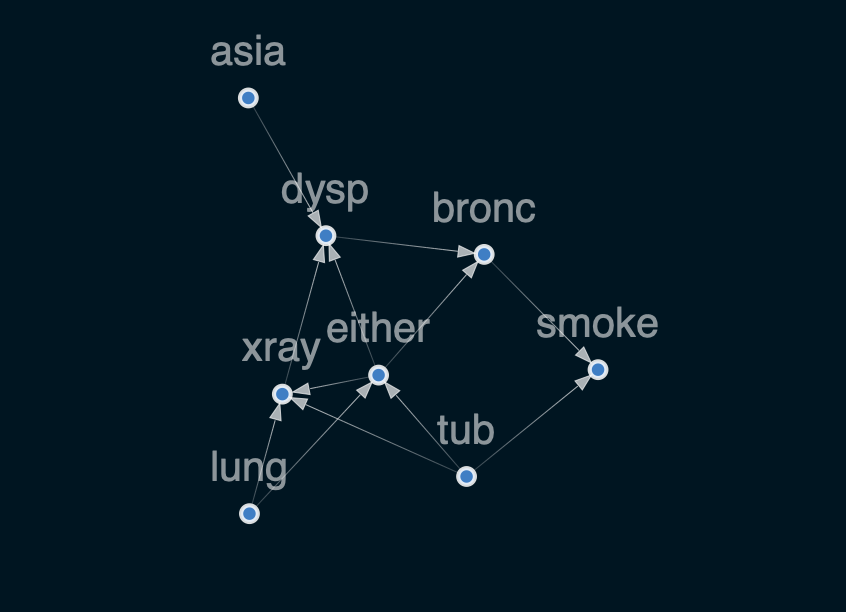

In [40]:
sm.remove_edges_below_threshold(0.2)
viz = plot_structure(
    sm,
    graph_attributes={"scale": "0.5"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK,
)
Image(viz.draw(format='png'))

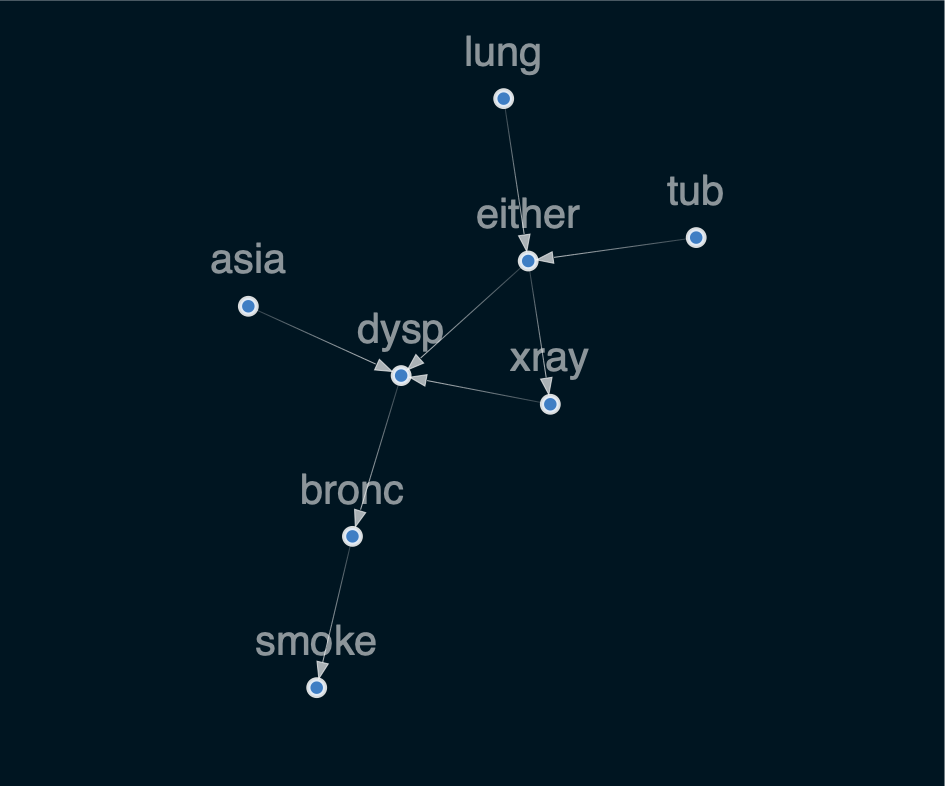

In [41]:
sm.remove_edges_below_threshold(0.3)
viz = plot_structure(
    sm,
    graph_attributes={"scale": "0.5"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK,
)
Image(viz.draw(format='png'))

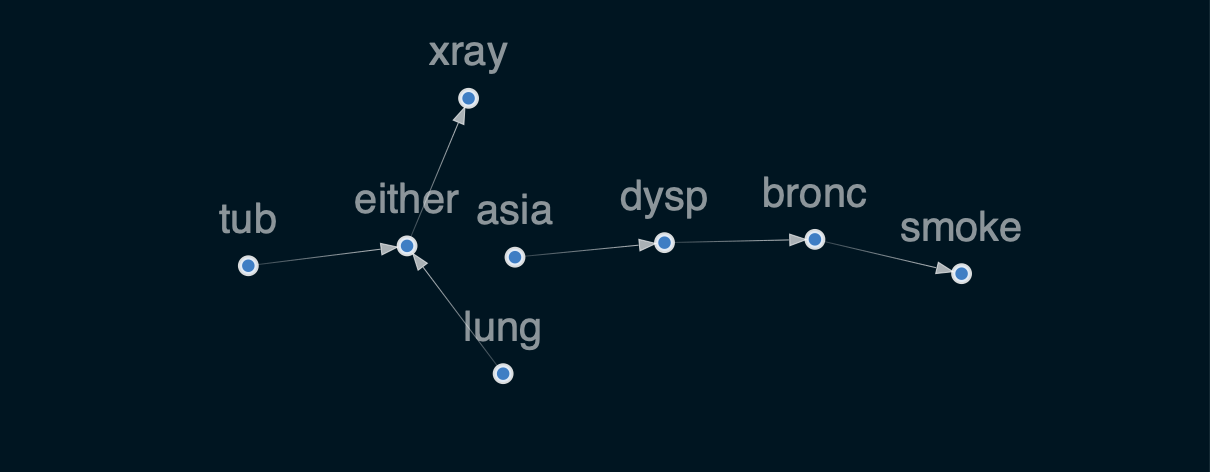

In [42]:
sm.remove_edges_below_threshold(0.4)
viz = plot_structure(
    sm,
    graph_attributes={"scale": "0.5"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK,
)
Image(viz.draw(format='png'))

As we reduce the threshold, we get closer to the expected graph, however, we have a series of incorrect or incorrectly oriented edges from 'asia' to 'dysp' to 'bronc' to 'smoke'. So for this dataset, the available graph learning did not perform well compared to the bnlearn library. We need to manually adjust the edges so we can do further work with the causalnex library. 

In [43]:
sm.remove_edge("dysp", "bronc")
sm.remove_edge("bronc", "smoke")
sm.remove_edge("asia","dysp")
sm.add_edge("smoke", "lung")
sm.add_edge("smoke", "bronc")
sm.add_edge("asia","tub")
sm.add_edge("bronc","dysp")
sm.add_edge("either", "dysp")

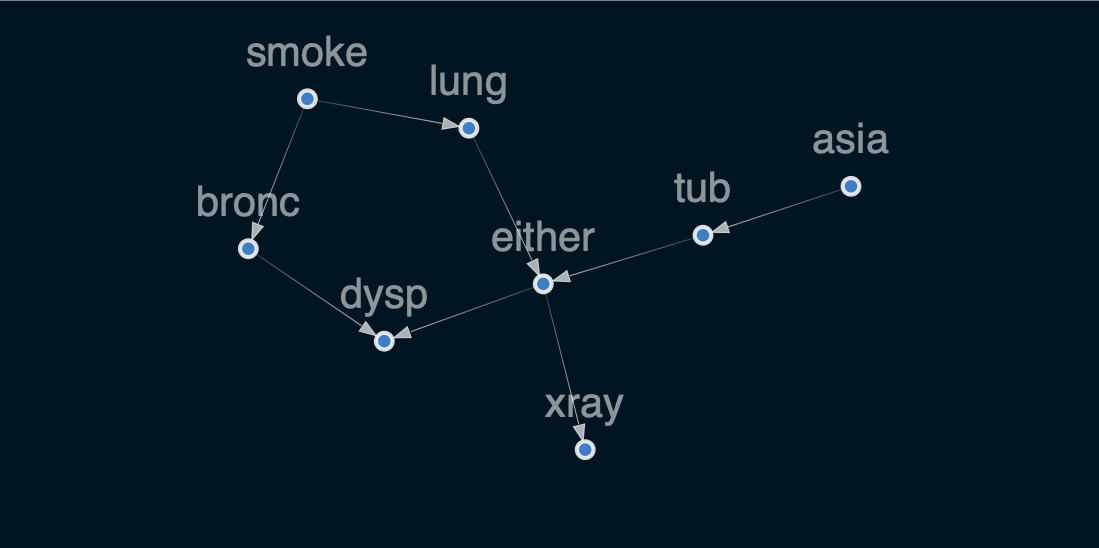

In [44]:
sm = sm.get_largest_subgraph()
viz = plot_structure(
    sm,
    graph_attributes={"scale": "0.5"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK,
)
Image(viz.draw(format='png'))

In [45]:
import networkx as nx
nx.drawing.nx_pydot.write_dot(sm, 'asia_graph.dot')

With our final structural model identified, we convert it to a bayesian network and split the data into two sets, a train set and test set. 

In [46]:
from causalnex.network import BayesianNetwork
bn = BayesianNetwork(sm)

In [47]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, train_size=0.9, test_size=0.1, random_state=7)

In [48]:
#specify which states each node can take
bn = bn.fit_node_states(df)

In [49]:
#fit the conditional probability distribution
bn = bn.fit_cpds(train, method="BayesianEstimator", bayes_prior="K2")

In [50]:
bn.cpds["dysp"]

bronc          0                   1          
either         0         1         0         1
dysp                                          
0       0.904822  0.298039  0.190772  0.100313
1       0.095178  0.701961  0.809228  0.899687

Conditional probability distribution for dyspnoea.

Evaluate the model using the test set.

In [51]:
from causalnex.evaluation import classification_report
classification_report(bn, test, "dysp")

{'dysp_0': {'precision': 0.9026717557251909,
  'recall': 0.8647166361974405,
  'f1-score': 0.8832866479925303,
  'support': 547},
 'dysp_1': {'precision': 0.8445378151260504,
  'recall': 0.8874172185430463,
  'f1-score': 0.8654467168998924,
  'support': 453},
 'accuracy': 0.875,
 'macro avg': {'precision': 0.8736047854256206,
  'recall': 0.8760669273702435,
  'f1-score': 0.8743666824462113,
  'support': 1000},
 'weighted avg': {'precision': 0.8763370806337802,
  'recall': 0.875,
  'f1-score': 0.8752051592075654,
  'support': 1000}}

The model has high precision and accuracy for both cases with and without dyspnoea. 

In [52]:
#retrain with full dataset
bn = bn.fit_cpds(df, method="BayesianEstimator", bayes_prior="K2")

In [53]:
from causalnex.inference import InferenceEngine
ie = InferenceEngine(bn)
marginals = ie.query()
marginals["dysp"]

{0: 0.5636032627932835, 1: 0.4363967372067164}

We see that within the data set, 43.64% of individuals have dyspnoea. We can also check the probability distribution for dyspnoea for those with and without bronchitis. 

In [54]:
marginals_b = ie.query({"bronc": 1})
marginals_nb = ie.query({"bronc": 0})
print("Marginal dysp | bronc", marginals_b["dysp"])
print("Marginal dysp | no bronc", marginals_nb["dysp"])

Marginal dysp | bronc {0: 0.18018041062946485, 1: 0.8198195893705351}
Marginal dysp | no bronc {0: 0.8728059620142267, 1: 0.12719403798577325}


Based on conditional probability distribution alone, we see that those with bronchitis have an 82% chance of also having dyspnoea. But these are only conditional probabilities, in causal networks, we want to be able to ask the quesiton, "if we force someone to have bronchitis, how likely are they to have dyspnoea" or any similar query based on do calculus. 

In [55]:
print("marginal dysp", ie.query()["dysp"])
ie.do_intervention("bronc",
                   {1: 1.0,
                    0: 0.0})
print("updated marginal dysp", ie.query()["dysp"])

marginal dysp {0: 0.5636032627932835, 1: 0.4363967372067164}
updated marginal dysp {0: 0.18146210191378767, 1: 0.8185378980862122}


In [56]:
ie.reset_do("bronc")

Here we see if we force bronchitis to be true, there is a 82% chance of having dyspnoea. What if we force bronchitis to be false? 

In [57]:
print("marginal dysp", ie.query()["dysp"])
ie.do_intervention("bronc",
                   {1: 0.0,
                    0: 1.0})
print("updated marginal dysp", ie.query()["dysp"])

marginal dysp {0: 0.5636032627932835, 1: 0.4363967372067164}
updated marginal dysp {0: 0.8657222474973097, 1: 0.13427775250269014}


In [58]:
ie.reset_do("bronc")

If we force bronchitis to take the value false, then we see there is only a 13% chance of having dyspnoea. We can easily run other queries on the dataset. 

In [59]:
marginals_bronc = ie.query({"either": 1})
marginals_no_bronc = ie.query({"either": 0})
print("Marginal dysp | either", marginals_bronc["dysp"])
print("Marginal dysp | neither", marginals_no_bronc["dysp"])


Marginal dysp | either {0: 0.1855159828290516, 1: 0.8144840171709483}
Marginal dysp | neither {0: 0.5892142338302052, 1: 0.41078576616979473}


In [60]:
print("marginal dysp", ie.query()["dysp"])
ie.do_intervention("either",
                   {1: 1.0,
                    0: 0.0})
print("updated marginal dysp", ie.query()["dysp"])

marginal dysp {0: 0.5636032627932835, 1: 0.4363967372067164}
updated marginal dysp {0: 0.205076356264583, 1: 0.794923643735417}


In [61]:
ie.reset_do("either")

In [65]:
marginals_smoke = ie.query({"smoke": 1})
marginals_no_smoke = ie.query({"smoke": 0})
print("Marginal dysp | smoking", marginals_smoke["dysp"])
print("Marginal dysp | no smoking", marginals_no_smoke["dysp"])

Marginal dysp | smoking {0: 0.443838833847134, 1: 0.5561611661528659}
Marginal dysp | no smoking {0: 0.6811845477998559, 1: 0.31881545220014407}


In [66]:
print("marginal dysp", ie.query()["dysp"])
ie.do_intervention("smoke",
                   {1: 1.0,
                    0: 0.0})
print("updated marginal dysp", ie.query()["dysp"])

marginal dysp {0: 0.5636032627932835, 1: 0.4363967372067164}
updated marginal dysp {0: 0.44383883384713396, 1: 0.5561611661528659}


In [67]:
ie.reset_do("smoke")

For this dataset, the causalnex library is able to provide the expected estimates for interventional queries. 

## Software Citations

###### BNLearn
repository-code: "https://github.com/erdogant/bnlearn"
title: "bnlearn - Library for Bayesian network learning and inference"
version: "0.3.22"
author:  
    family-names: Taskesen
    given-names: Erdogan
    
###### DoWhy
Amit Sharma, Emre Kiciman, et al. DoWhy: A Python package for causal inference. 2019. https://github.com/microsoft/dowhy

###### Asia Data Set 
Center for Causal Discovery Wiki
Data Science Research
https://www.ccd.pitt.edu/wiki/index.php/Data_Repository

S. Lauritzen, D. Spiegelhalter. Local Computation with Probabilities on Graphical Structures and their Application to Expert Systems (with discussion). Journal of the Royal Statistical Society: Series B (Statistical Methodology), 50(2):157-224, 1988.


###### Causalnex
https://causalnex.readthedocs.io/en/latest/

@article{scikit-learn,
 title={Scikit-learn: Machine Learning in {P}ython},
 author={Pedregosa, F. and Varoquaux, G. and Gramfort, A. and Michel, V.
         and Thirion, B. and Grisel, O. and Blondel, M. and Prettenhofer, P.
         and Weiss, R. and Dubourg, V. and Vanderplas, J. and Passos, A. and
         Cournapeau, D. and Brucher, M. and Perrot, M. and Duchesnay, E.},
 journal={Journal of Machine Learning Research},
 volume={12},
 pages={2825--2830},
 year={2011}
}

#### BNLearn

authors: 

    family-names: Taskesen

    given-names: Erdogan
    
    orcid: "https://orcid.org/0000-0002-3430-9618"

cff-version: "1.1.0"
date-released: 2020-01-02
keywords: 
  - "Bayesian-inference"
  - "Structure learning"
  - "Parameter learning"
  - "Causal relationships"
license: "MIT"

message: "If you use this software, please cite it using these metadata."

repository-code: "https://github.com/erdogant/bnlearn"

title: "bnlearn - Library for Bayesian network learning and inference"

version: "0.3.22"
...

#### Causalnex

cff-version: 1.2.0
message: "If you'd like to cite CausalNex, please use the following metadata"
authors:
- family-names: "Beaumont"
  given-names: "Paul"
- family-names: "Horsburgh"
  given-names: "Ben"
- family-names: "Pilgerstorfer"
  given-names: "Philip"
- family-names: "Droth"
  given-names: "Angel"
- family-names: "Oentaryo"
  given-names: "Richard"
- family-names: "Ler"
  given-names: "Steven"
- family-names: "Nguyen"
  given-names: "Hiep"
- family-names: "Ferreira"
  given-names: "Gabriel Azevedo"
- family-names: "Patel"
  given-names: "Zain"
- family-names: "Leong"
  given-names: "Wesley"

title: "CausalNex"

date-released: 2021-10-15

url: "https://github.com/quantumblacklabs/causalnex"